In [1]:
import torch
from torch import nn
import torch.optim as optim
import pygame
import json 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import time

d:\Code\University\Code_LMU\GAN-BERT-Classifier\py39env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.5.0 (SDL 2.28.0, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# SCREEN_WIDTH    = 100
# SCREEN_HEIGHT   = 20
# FONT_SIZE       = 10 

SEED = 0    
random.seed(SEED)
torch.manual_seed(SEED)

SCREEN_WIDTH    = 130
SCREEN_HEIGHT   = 25
FONT_SIZE       = 15 
# 4680
# TODO: better config font

FONT_PATH_Noto_sans     = "../converttext/noto-sans.regular.ttf"
FONT_PATH_Typographer   = "../converttext/TypographerTextur-Regular.ttf"
FONT_PATH_Turok         = "../converttext/turok.ttf"
FONT_PATH_Mandatory     = "../converttext/mandatory.ttf"



PATH_WORD_NUM_DICT  = 'word_num_dict.json'
PATH_WORD_TO_ID     = 'word_to_id_dict.json'
PATH_ID_TO_WORD     = 'id_to_word_dict.json'

DEVICE_NAME         = "cuda:0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_OUT_CHANNELS  = 16
MODEL_KERNEL_SIZE   = 3
MODEL_SITRIDE       = 1
MODEL_PADDING       = 1
MODEL_LINEAR_SIZE   = 12480
OPTIM_LEARNING_RATE = 0.001

TRAIN_BATCH_SIZE    = 16
DEV_BATCH_SIZE      = 16
TRAIN_NUM_EPOCHS    = 10

PATH_FOLDER_NAME = f"CNN_{time.strftime('%m_%d_%H_%M_%S', time.localtime())}"
# PATH_FOLDER_NAME = f"CNN_"
if not os.path.exists(PATH_FOLDER_NAME):
    os.mkdir(PATH_FOLDER_NAME)

PATH_CONFIG = f"./{PATH_FOLDER_NAME}/config.json"
PATH_TRAIN_LOSS_PLOT = f"./{PATH_FOLDER_NAME}/train_loss.jpg"
PATH_DEV_ACC_PLOT    = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"
PATH_DEV_CONF_PLOT   = f"./{PATH_FOLDER_NAME}/dev_loss.jpg"

PATH_DATA   = f"./{PATH_FOLDER_NAME}/train_data.csv"    # 
PATH_EVALUATE_DATA_PREFIX   = f"./{PATH_FOLDER_NAME}/eval_data"    # 
PATH_MODEL  = f"./{PATH_FOLDER_NAME}/CNN.pth"
PATH_MODEL_PREFIX  = f"./{PATH_FOLDER_NAME}/CNN_"

# evaluation
PATH_NOISE_DICT_LEETSPEAK   = "./letter_to_leetspeak.json"
PATH_NOISE_DICT_GREEK       = "./letter_to_greek_dict.json"
PATH_NOISE_DICT_CYRILLIC    = "./letter_to_cyrillic_dict.json"

In [3]:
config = {
"seed"                  : SEED,
"screen_width"          : SCREEN_WIDTH,
"screen_height"         : SCREEN_HEIGHT,
"font_size"             : FONT_SIZE,
"FONT_PATH_Noto_sans"   : FONT_PATH_Noto_sans  , 
"FONT_PATH_Typographer" : FONT_PATH_Typographer, 
"FONT_PATH_Turok"       : FONT_PATH_Turok      , 
"FONT_PATH_Mandatory"   : FONT_PATH_Mandatory  , 
"path_word_num_dict"    : PATH_WORD_NUM_DICT,
"path_word_to_id"       : PATH_WORD_TO_ID,
"path_id_to_word"       : PATH_ID_TO_WORD,
"device_name"           : DEVICE_NAME,
"model_out_channels"    : MODEL_OUT_CHANNELS,
"model_kernel_size"     : MODEL_KERNEL_SIZE,
"model_sitride"         : MODEL_SITRIDE,
"model_padding"         : MODEL_PADDING,
"model_linear_size"     : MODEL_LINEAR_SIZE,
"optim_learning_rate"   : OPTIM_LEARNING_RATE,
"train_batch_size"      : TRAIN_BATCH_SIZE,
"dev_batch_size"        : DEV_BATCH_SIZE,
"train_num_epochs"      : TRAIN_NUM_EPOCHS,
}

with open(PATH_CONFIG, 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

In [4]:
class CNN(nn.Module):
    def __init__(self, out_channels=6, kernel_size=1, stride=1, padding=0, vocab_size=5000, linear_size=5000, normalization=False):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=out_channels, 
            kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(linear_size, vocab_size) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [5]:
pygame.init()

font_noto_sans_regular  = pygame.font.Font(FONT_PATH_Noto_sans, FONT_SIZE)
font_noto_typographer   = pygame.font.Font(FONT_PATH_Typographer, FONT_SIZE)
font_noto_turok         = pygame.font.Font(FONT_PATH_Turok, FONT_SIZE)
font_noto_mandatory     = pygame.font.Font(FONT_PATH_Mandatory, FONT_SIZE)


def to_image(text:str, font_str="noto_sans", id:int=None, noise=False, noise_type=None, noise_original_word=""):
  # pygame.init()
  # screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
  if font_str == "noto_sans":
    font = font_noto_sans_regular
  if font_str == "typographer":
    font = font_noto_typographer
  if font_str == "turok":
    font = font_noto_turok
  if font_str == "mandatory":
    font = font_noto_mandatory
  
  
  screen = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))
  screen.fill((255, 255, 255))
  # draw image
  img = font.render(str(text), True, (0, 0, 0))
  screen.blit(img, (2, 0))
  for event in pygame.event.get():
    if event.type == pygame.QUIT:
      run = False
  # pygame.display.flip() 
  # Save the screen as an image when the program finishes
  if noise == False:
    # TODO: obtain font name
    filename = f"./temp_image/word_{str(id)}_{str(text)}_{font_str}.png"
  else:
    filename = f"./temp_image/word_{str(id)}_{str(noise_original_word)}_{font_str}_noised_{noise_type}.png"
  pygame.image.save(screen, filename)
  # print("Screen saved as ", filename)
  # pygame.quit()
  return filename

image_path = to_image(text="1nd1st1nguishαble", font_str="noto_sans", id=5, noise=False)


In [6]:
# load dictionary

with open(PATH_WORD_NUM_DICT, 'r') as fp:
    word_num_dict_test = json.load(fp)
with open(PATH_WORD_TO_ID, 'r') as fp:
    word_to_id_dict_test = json.load(fp)
with open(PATH_ID_TO_WORD, 'r') as fp:
    id_to_word_dict_test = json.load(fp)
    
print("test load: length of word_num_dict:", len(word_num_dict_test.keys()))
print("test load: length of word_to_id_dict_test:", len(word_to_id_dict_test.keys()))
print("test load: length of id_to_word_dict_test:", len(id_to_word_dict_test.keys()))
print('note index needs to use str(index)')
print(f"test load: index: [5], word in id_to_word_dict: [{id_to_word_dict_test[str(5)]}], id in word_id_dict: [{word_to_id_dict_test[id_to_word_dict_test['5']]}]")

VOCAB_SIZE = len(word_num_dict_test.keys())


test load: length of word_num_dict: 4572
test load: length of word_to_id_dict_test: 4572
test load: length of id_to_word_dict_test: 4572
note index needs to use str(index)
test load: index: [5], word in id_to_word_dict: [defines], id in word_id_dict: [5]


In [7]:
# define dataset

transform_norm = transforms.Compose([
    transforms.ToTensor(),
])
class WordImageIDDataset(Dataset):
    def __init__(self, word_to_id_list, font_str, noise=False):
        self.word_to_id_list = word_to_id_list
        self.font_str = font_str
        self.noise = noise
    
    def __len__(self):
        return len(self.word_to_id_list)
    
    def __getitem__(self, index):
        ''' index is not token ID '''
        output_word = self.word_to_id_list[index][0]
        image_path  = to_image(
            text    = output_word, 
            font_str= self.font_str,
            id      = index, 
            noise   = self.noise
            )
        
        # for path in image_paths:
        output_img = Image.open(image_path).convert('L')
        output_img = transform_norm(output_img)
        id = self.word_to_id_list[index][1]
        # output_id_onehot = torch.zeros(1, VOCAB_SIZE)
        # output_id_onehot[0][id] = 1
        output_id_onehot = torch.zeros(VOCAB_SIZE)
        output_id_onehot[id] = 1
                
        output = {'word'    : output_word,
                  'image'   : output_img,
                  'id'      : output_id_onehot}
        return output

↑ codes above are settings ↑

#### Training

In [8]:
# font_str = "noto_sans"
# font_str = "typographer"
# font_str = "turok"
font_str = "mandatory"

In [9]:
model = CNN(out_channels=MODEL_OUT_CHANNELS, 
            kernel_size=MODEL_KERNEL_SIZE, 
            stride=MODEL_SITRIDE, 
            padding=MODEL_PADDING, vocab_size=VOCAB_SIZE, normalization=False, linear_size=MODEL_LINEAR_SIZE).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=OPTIM_LEARNING_RATE)
dataset = WordImageIDDataset(
    word_to_id_list = list(word_to_id_dict_test.items()),
    font_str=font_str,
    noise=False)
train_dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)


epoch: 1
10.075105203615202
acc: 0.1714785651793526
epoch: 2
7.666108624918477
acc: 0.38123359580052496
epoch: 3
4.038295285685079
acc: 0.7117235345581803
epoch: 4
1.3752710634803438
acc: 0.8888888888888888
epoch: 5
0.5690237494719612
acc: 0.9326334208223972
epoch: 6
0.31714098604877927
acc: 0.9639107611548556
epoch: 7
0.20639284755513593
acc: 0.9750656167979003
epoch: 8
0.13933008657182222
acc: 0.9820647419072616
epoch: 9
0.11234948840448176
acc: 0.984251968503937
epoch: 10
0.09347238127545981
acc: 0.9855643044619422


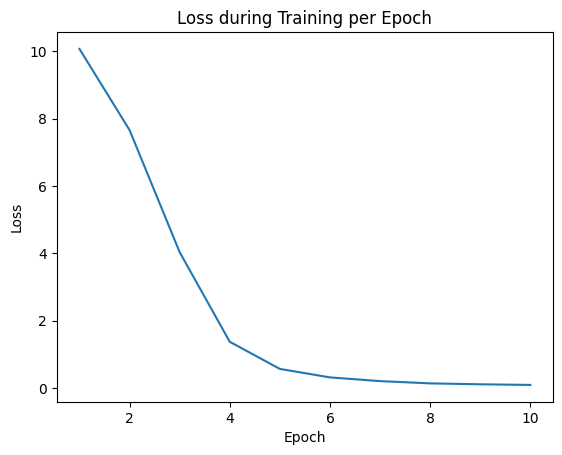

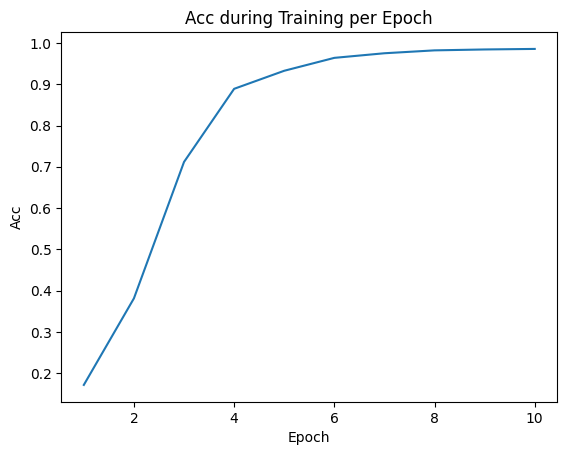

In [10]:
train_loss = []
epoch_acc = []
for epoch in range(1, TRAIN_NUM_EPOCHS + 1):
    print(f'epoch: {epoch}')
    model.train()
    epoch_loss = []

    for data in train_dataloader:
        words    = data['word']
        imgs     = data['image']
        ids      = data['id']
        optimizer.zero_grad()
        # print(word)
        # print(imgs.shape)
        # print(id)
        # print(ids.shape)
        # read image    
        outputs = model(imgs.to(device))
        # print(output)
        # softmax = torch.nn.Softmax()
        # outputs = softmax(outputs)
        # print(pred) 
        # print(preds.shape)
        # print(ids.shape)
        
        loss = criterion(outputs, ids.to(device))
        # print("Loss:", loss.item())
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        # torch.cuda.empty_cache()
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print(epoch_average_loss)
    train_loss.append(epoch_average_loss)

    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in eval_dataloader:
            words    = data['word']
            imgs     = data['image']
            ids      = data['id']
            outputs = model(imgs.to(device))
            _, targets = torch.max(ids.data, 1)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets.to(device)).sum().item()
    epoch_acc.append(correct/total)
    print(f"acc: {epoch_acc[-1]}")
x = range(1, TRAIN_NUM_EPOCHS+1)
plt.plot(x, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training per Epoch')
plt.savefig(PATH_TRAIN_LOSS_PLOT)
plt.show()

plt.plot(x, epoch_acc)
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc during Training per Epoch')
plt.savefig(PATH_DEV_ACC_PLOT)
plt.show()

In [11]:
# save the loss and acc during training
data = pd.DataFrame({'train_loss':train_loss,
                     'train_acc':epoch_acc})

data.to_csv(PATH_DATA)


In [12]:
torch.save(model, f"{PATH_MODEL_PREFIX}_{font_str}.pth")

#### Evaluate the final accuracy 

In [ ]:
model = torch.load(PATH_MODEL)


In [ ]:
eval_dataloader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    all_word_list       = []
    all_id_list         = []
    all_pred_id_list    = []
    all_compare_list    = []
    
    for data in eval_dataloader:
        # data = next(iter(eval_dataloader))
        # data = next(iter(eval_dataloader))
        words    = data['word']     # list
        imgs     = data['image']
        ids      = data['id']
        
        outputs = model(imgs.to(device))
        _, targets = torch.max(ids.data, 1)         # torch.Size([16])
        _, predicted = torch.max(outputs.data, 1)   # torch.Size([16])
        # print("words: ", len(words))
        # print("ids: ", ids.shape)
        # print("targets: ", targets.shape)
        # print("targets: ", targets.tolist())
        # print("outputs: ", outputs.shape)
        # print("predicted: ", predicted.shape)
        total += targets.size(0)
        compare = predicted == targets.to(device)
        # print("compare: ", compare.shape)
        correct += compare.sum().item()             # torch.Size([16])
        
        all_word_list.extend(words)
        all_id_list.extend(targets.tolist())
        all_pred_id_list.extend(predicted.tolist())
        all_compare_list.extend(compare.tolist())
        # print("targets: ", targets)
        # print("predicted: ", predicted)
        # print("correct: ", correct)
        # break
    evaluate_acc = correct/total
    print(evaluate_acc)

In [ ]:
print(all_word_list   )
print(all_id_list     )
print(all_pred_id_list   )
print(all_compare_list)
all_pred_word_list = [id_to_word_dict_test[str(pred_id)] for pred_id in all_pred_id_list]
print(all_pred_word_list)

evaluate_data = pd.DataFrame({'word':all_word_list,
                     'real_id':all_id_list,
                     'pred_word':all_pred_word_list,
                     'pred_id':all_pred_id_list,
                     'eval':all_compare_list,
                     })

evaluate_data.to_csv(PATH_EVALUATE_DATA_PREFIX+f"_{round(evaluate_acc*100, 2)}.csv")


#### Evaluation of different proportion of noise

leetspeak: https://github.com/floft/leetspeak/blob/master/LeetSpeak.py

unicode (Cyrillic): https://www.russlandjournal.de/en/learn-russian/russian-alphabet/

unicode (greek): https://web.mit.edu/jmorzins/www/greek-alphabet.html

In [ ]:
model = torch.load(PATH_MODEL)
NOISE_TYPE  = "greek"
NOISE_TYPE  = "cyrillic"
NOISE_TYPE  = "leetspeak" # TODO: fix bug

NOISE_P     = 0.5
NOISE_P     = 0.4
NOISE_P     = 0.3
NOISE_P     = 0.2
NOISE_P     = 0.1

font_str = "noto_sans"
# font_str = "typographer"
# font_str = "turok"
# font_str = "mandatory"

In [ ]:
class WordImageID_Noise_Dataset(Dataset):
    def __init__(self, word_to_id_list, font_str:str="noto_sans", isNoise:bool=False, noise_dict=None, noise_p:float=0.5, noise_type:str=""):
        self.word_to_id_list = word_to_id_list
        # self.font       = font
        self.font_str   = font_str
        self.isNoise    = isNoise
        self.noise_dict = noise_dict
        self.noise_p    = noise_p
        self.noise_type = noise_type
        if isNoise:
            if noise_dict == None:
                print("Error: noise_dict is None, while isNoise is True")
    
    def __len__(self):
        return len(self.word_to_id_list)
    
    def __getitem__(self, index):
        ''' index is not token ID '''
        output_word_original = self.word_to_id_list[index][0]
        output_word_noised   = ""
        output_word_length   = len(output_word_original)
        output_noise_length  = 0
        if self.isNoise: # create noise word
            output_word_noised = ""
            for letter in output_word_original:
                p = random.random()
                if p < self.noise_p:
                    try:
                        if self.noise_dict[letter] != "":    
                            output_word_noised += self.noise_dict[letter]
                            output_noise_length += 1
                        else:
                            # case: no approperate noise defined for this letter
                            output_word_noised += letter
                    except Exception:
                        # TODO: letter OOV problem
                        print(f"Warning: [{letter}] from [{output_word_original}] is not an English letter")
                        output_word_noised += letter
                else:
                    output_word_noised += letter
        if self.isNoise: # select which word to render
            word_for_render = output_word_noised
        else:
            word_for_render = output_word_original
        
        word_id = self.word_to_id_list[index][1]     
        image_path  = to_image(     # TODO: original word in file name
            text    = word_for_render, 
            font_str= self.font_str,
            id      = word_id,          # TODO: here should be ID
            noise   = self.isNoise,     # TODO: noise -> isNoise
            noise_original_word = output_word_original,
            noise_type = self.noise_type,
        )

        # for path in image_paths:
        output_img = Image.open(image_path).convert('L')
        output_img = transform_norm(output_img)
        
        output_id_onehot = torch.zeros(VOCAB_SIZE)
        output_id_onehot[word_id] = 1
                
        output = {'word'        : output_word_original,
                  'word_noised' : output_word_noised,
                  'image'       : output_img,
                  'id'          : output_id_onehot,
                  'word_length' : str(output_word_length),
                  'noise_length': str(output_noise_length),
                  'noise_pers'  : str(round((output_noise_length / output_word_length)*100, 2))
                  }
        return output

In [ ]:
with open(PATH_NOISE_DICT_LEETSPEAK, 'r', encoding="utf-8") as fp:
    noise_dict_leetspeak = json.load(fp)
with open(PATH_NOISE_DICT_GREEK, 'r', encoding="utf-8") as fp:
    noise_dict_greek = json.load(fp)
with open(PATH_NOISE_DICT_CYRILLIC, 'r', encoding="utf-8") as fp:
    noise_dict_cyrillic = json.load(fp)

print("length of noise dict leetspeak:", len(noise_dict_leetspeak.keys()))
print("length of noise dict greek:", len(noise_dict_greek.keys()))
print("length of noise dict cyrillic:", len(noise_dict_cyrillic.keys()))

In [ ]:
if NOISE_TYPE == "leetspeak":
    noise_dict = noise_dict_leetspeak
if NOISE_TYPE == "greek":
    noise_dict = noise_dict_greek
if NOISE_TYPE == "cyrillic":
    noise_dict = noise_dict_cyrillic
    
dataset_eval_noise = WordImageID_Noise_Dataset(
    word_to_id_list = list(word_to_id_dict_test.items()),
    # font        = font_noto_sans_regular,
    font_str    = font_str,
    isNoise     = True, 
    noise_dict  = noise_dict,
    noise_p     = NOISE_P,
    noise_type  = NOISE_TYPE,
    )
eval_noise_dataloader = DataLoader(dataset_eval_noise, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    all_word_list        = []
    all_word_noised_list = []
    all_id_list          = []
    all_word_length_list = []
    all_noise_length_list= []
    all_noises_pers      = []
    all_pred_id_list     = []
    all_compare_list     = []
    
    for data in eval_noise_dataloader:
        # data = next(iter(eval_dataloader))
        words    = data['word']     # list
        imgs     = data['image']
        ids      = data['id']
        words_noised    = data['word_noised']
        words_length    = data['word_length']
        noises_length   = data['noise_length']
        noises_pers     = data['noise_pers']
        
        outputs = model(imgs.to(device))
        _, targets = torch.max(ids.data, 1)         # torch.Size([16])
        _, predicted = torch.max(outputs.data, 1)   # torch.Size([16])
        # print("words: ", len(words))
        # print("ids: ", ids.shape)
        # print("targets: ", targets.shape)
        # print("targets: ", targets.tolist())
        # print("outputs: ", outputs.shape)
        # print("predicted: ", predicted.shape)
        total += targets.size(0)
        compare = predicted == targets.to(device)
        # print("compare: ", compare.shape)
        correct += compare.sum().item()             # torch.Size([16])
        
        all_word_list.extend(words)
        all_word_noised_list.extend(words_noised)
        all_id_list.extend(targets.tolist())
        all_word_length_list.extend(words_length)
        all_noise_length_list.extend(noises_length)
        all_noises_pers.extend(noises_pers)
        all_pred_id_list.extend(predicted.tolist())
        all_compare_list.extend(compare.tolist())
        # print("targets: ", targets)
        # print("predicted: ", predicted)
        # print("correct: ", correct)
        # break
    evaluate_acc = correct/total
    print(evaluate_acc)

In [ ]:
print(len(all_word_list        ))
print(len(all_word_noised_list ))
print(len(all_id_list          ))
print(len(all_word_length_list ))
print(len(all_noise_length_list))
print(len(all_noises_pers      ))
print(len(all_pred_id_list     ))
print(len(all_compare_list     ))


all_pred_word_list = [id_to_word_dict_test[str(pred_id)] for pred_id in all_pred_id_list]
print(len(all_pred_word_list))

evaluate_noise_data = pd.DataFrame({
    'word'      : all_word_list,
    'real_id'   : all_id_list,
    'noise_word': all_word_noised_list,
    'pred_word' : all_pred_word_list,
    'pred_id'   : all_pred_id_list,
    'eval'      : all_compare_list,
    'word_len'  : all_word_length_list,
    "noise_len" : all_noise_length_list,
    "noise_pers": all_noises_pers
    })

evaluate_noise_data.to_csv(PATH_EVALUATE_DATA_PREFIX+f"{font_str}_{NOISE_TYPE}_p{NOISE_P}_{round(evaluate_acc*100, 2)}_s{SEED}.csv", 
                           encoding="utf-8-sig")
